# US Babe Names 1880-2015

This demo is based on an example in the book: https://www.amazon.com/dp/1449319793/

_Python for Data Analysis_ by William Wesley McKinney (O'Reilly). Copyright 2012 William McKinney, 978-1-449-31979-3

The data can be download from:
https://catalog.data.gov/dataset/baby-names-from-social-security-card-applications-national-level-data

## Setup

- Install Anaconda from https://www.continuum.io/downloads
- Set the account name, user name and password to the environment variables to ``SF_ACCOUNT``, ``SF_USER`` and ``SF_PASSWORD``
- Set the S3 Bucket, AWS access key id and AWS secret access key to ``SF_S3_BUCKET``, ``AWS_ACCESS_KEY_ID`` and ``AWS_SECRET_ACCESS_KEY`` to load the daata from the given location.
- Start Jupyter notebook
```jupyter notebook```

The given data files are named in the form of ``yobi<year>.txt``. For example, the baby names in 1880 is included in ``yobi1880.txt``. The data row format is:
- name
- gender
- births

Since no year is included, I did run a bash script to preprocess the data:

<pre>
#!/bin/bash
gzip *.txt
for f in $(ls *.txt.gz); do
    year=${f:3:4}
    new_name=${f:0:7}"u.tar.gz"
    zcat $f | awk -v year="$year" '{ gsub(/\r$/,""); print $0 "," year}' | gzip -c > ${f:0:7}"u.tar.gz"
    aws s3 cp $new_name s3://{s3_bucket}/baby_names/data/
done
</pre>

In [1]:
import os
account=os.getenv('SF_ACCOUNT')
user=os.getenv('SF_USER')
password=os.getenv('SF_PASSWORD')
aws_key=os.getenv("AWS_ACCESS_KEY_ID")
aws_secret = os.getenv("AWS_SECRET_ACCESS_KEY")
sf_s3_bucket=os.getenv("SF_S3_BUCKET")

## Create Tables and Load Data

In [2]:
from snowflake.connector import connect
con = connect(
    account=account,
    user=user,
    password=password,
    database='testdb',
    schema='public',
)
cur = con.cursor()

In [3]:
cur.execute("""
create or replace table baby_names(
    name   string,
    gender varchar(1),
    births integer,
    year   integer)""")

In [4]:
cur.execute("""
copy into baby_names from s3://{s3_bucket}/baby_names/data/
    credentials=(
        aws_key_id='{aws_key_id}' 
        aws_secret_key='{aws_secret_key}'
    )
    file_format= (
        field_delimiter=','
        type='csv'
    )
""".format(
        s3_bucket=sf_s3_bucket,
        aws_key_id=aws_key,
        aws_secret_key=aws_secret))

## Data Analysis

In [5]:
import pandas as pd

In [6]:
from sqlalchemy import create_engine
from snowflake.sqlalchemy import URL
engine = create_engine(URL(
    account=account,
    user=user,
    password=password,
    database='testdb',
    schema='public',
    numpy=True,
    ))

In [7]:
names1880 = pd.read_sql("""
SELECT name, gender, births
  FROM baby_names
 WHERE year=1880""", engine)

In [8]:
names1880.groupby('gender')['births'].sum()

gender
F     90992
M    110490
Name: births, dtype: int64

In [9]:
names=pd.read_sql("""
SELECT *
  FROM baby_names""", engine)

In [10]:
total_births=pd.pivot_table(
    names,
    values='births',
    index='year',
    columns='gender',
    aggfunc='sum')

In [11]:
total_births.tail()

gender,F,M
year,,
2011,1754424,1894262
2012,1755254,1890889
2013,1747544,1883945
2014,1777242,1910876
2015,1769325,1898858


In [12]:
%matplotlib notebook

<IPython.core.display.Javascript object>


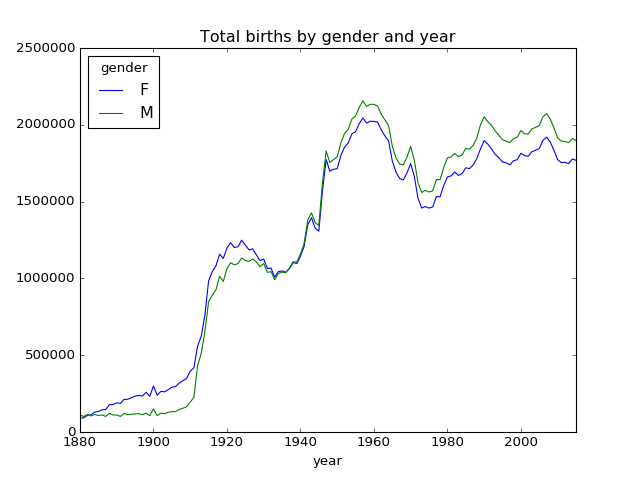

In [13]:
total_births.plot(title='Total births by gender and year')

In [14]:
def add_prop(group):
    # Integer division floor
    births = group.births.astype(float)
    group['prop'] = births / births.sum()
    return group

In [15]:
names=names.groupby(['year','gender']).apply(add_prop)

In [16]:
names.head()

,name,gender,births,year,prop
0,Mary,F,8148,1882,0.075551
1,Anna,F,3143,1882,0.029143
2,Emma,F,2303,1882,0.021354
3,Elizabeth,F,2186,1882,0.020269
4,Minnie,F,2004,1882,0.018582


In [17]:
import numpy as np

In [18]:
np.allclose(names.groupby(['year','gender']).prop.sum(),1)

True

In [19]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
grouped=names.groupby(['year','gender'])
top1000=grouped.apply(get_top1000)
top1000.index = np.arange(len(top1000))

In [20]:
pieces=[]
for year, group in names.groupby(['year','gender']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])
top1000=pd.concat(pieces, ignore_index=True)

In [21]:
top1000

,name,gender,births,year,prop
0,Mary,F,7065,1880,0.077644
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021310
4,Minnie,F,1746,1880,0.019189
5,Margaret,F,1578,1880,0.017342
6,Ida,F,1472,1880,0.016177
7,Alice,F,1414,1880,0.015540
8,Bertha,F,1320,1880,0.014507
9,Sarah,F,1288,1880,0.014155


## Analyzing Naming Trends

In [22]:
boys=top1000[top1000.gender=='M']

In [23]:
girls=top1000[top1000.gender=='F']

In [24]:
total_births=pd.pivot_table(
    names,
    values='births',
    index='year',
    columns='name',
    aggfunc='sum')

In [25]:
total_births.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 1880 to 2015
Columns: 95025 entries, Aaban to Zzyzx
dtypes: float64(95025)
memory usage: 98.6 MB


In [26]:
subset=total_births[['John', 'Harry', 'Mary', 'Marilyn']]

<IPython.core.display.Javascript object>


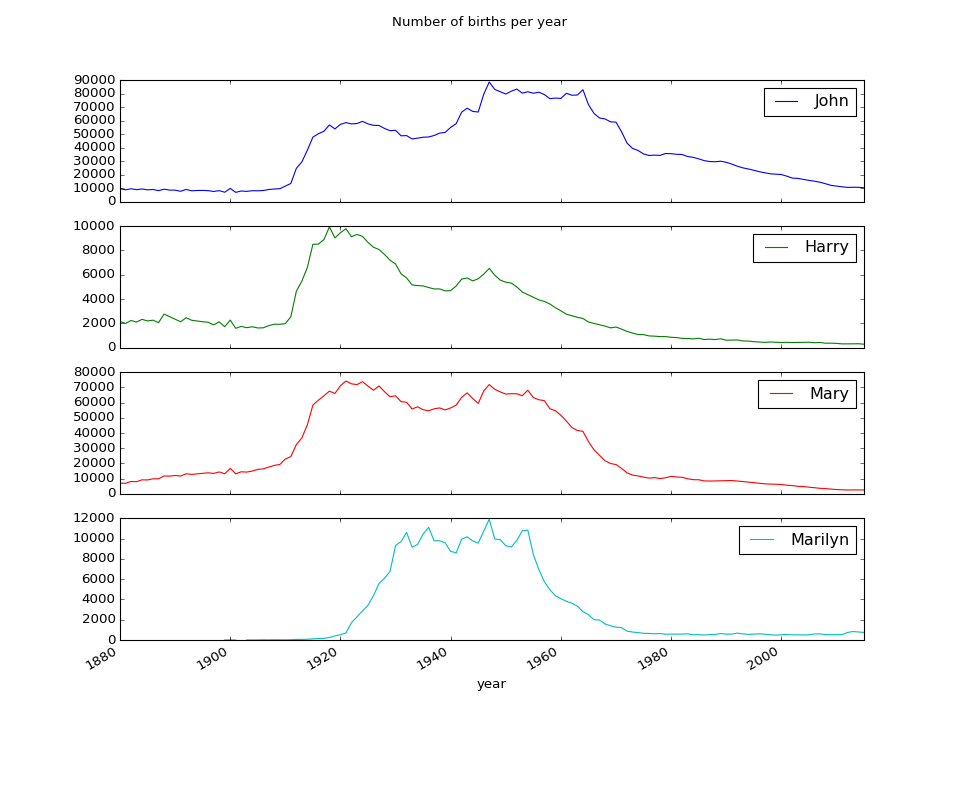

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f90d1a28f60>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f90d1c36908>], dtype=object)

In [27]:
subset.plot(subplots=True, figsize=(12,10), grid=False, title="Number of births per year")

### Measuring the increase in naming diversity

In [28]:
table=pd.pivot_table(
    top1000,
    values='prop',
    index='year',
    columns='gender',
    aggfunc='sum'
)

<IPython.core.display.Javascript object>


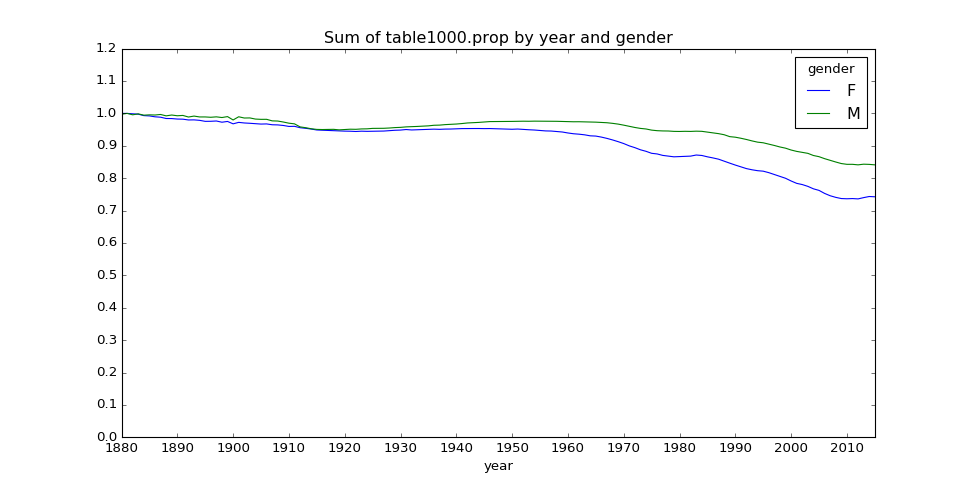

In [29]:
table.plot(title='Sum of table1000.prop by year and gender',
          yticks=np.linspace(0, 1.2, 13),
          xticks=range(1880, 2020, 10))

In [31]:
df=boys[boys.year==2010]

In [32]:
df

,name,gender,births,year,prop
260877,Jacob,M,22095,2010,0.011540
260878,Ethan,M,17993,2010,0.009398
260879,Michael,M,17324,2010,0.009048
260880,Jayden,M,17158,2010,0.008962
260881,William,M,17036,2010,0.008898
260882,Alexander,M,16746,2010,0.008746
260883,Noah,M,16438,2010,0.008585
260884,Daniel,M,15819,2010,0.008262
260885,Aiden,M,15520,2010,0.008106
260886,Anthony,M,15475,2010,0.008083


In [33]:
prop_cumsum=df.sort_values(by='prop', ascending=False).prop.cumsum()

In [34]:
prop_cumsum[:10]

260877    0.011540
260878    0.020938
260879    0.029986
260880    0.038947
260881    0.047845
260882    0.056592
260883    0.065177
260884    0.073439
260885    0.081545
260886    0.089628
Name: prop, dtype: float64

In [35]:
prop_cumsum.values.searchsorted(0.5)

116

In [36]:
df=boys[boys.year==1900]

In [37]:
in1900=df.sort_values(by='prop', ascending=False).prop.cumsum()

In [38]:
in1900.values.searchsorted(0.5)+1

25

In [39]:
def get_quantile_count(group, q=0.5):
    group=group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q)+1
diversity=top1000.groupby(['year','gender']).apply(get_quantile_count)
diversity=diversity.unstack('gender')

In [40]:
diversity.head()

gender,F,M
year,,
1880,38,14
1881,38,14
1882,38,15
1883,39,15
1884,39,16


<IPython.core.display.Javascript object>


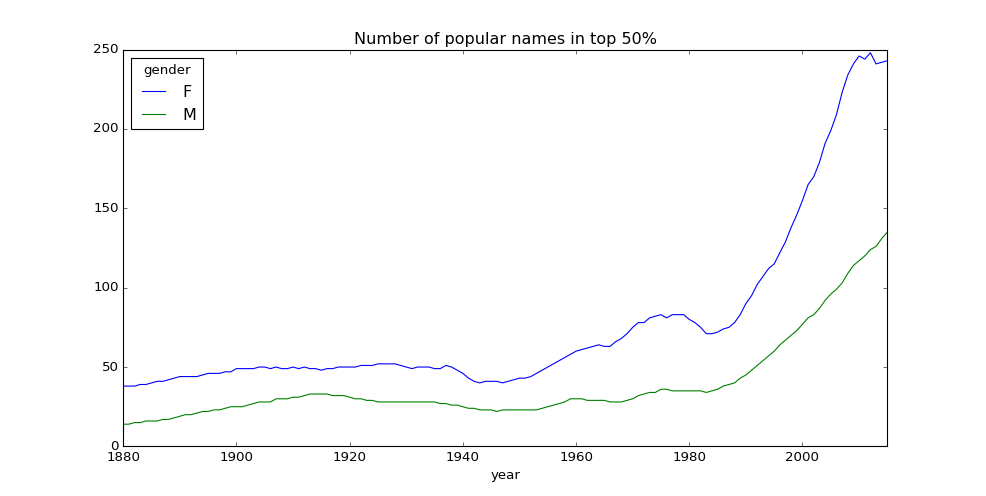

In [41]:
diversity.plot(title='Number of popular names in top 50%')

### The "Last letter" revolution

In [42]:
get_last_letter = lambda x: x[-1]
last_letters=names.name.map(get_last_letter)
last_letters.name = 'last_letter'
table = pd.pivot_table(
    names,
    values='births',
    index=last_letters,
    columns=['gender', 'year'],
    aggfunc='sum'
)

In [43]:
subtable=table.reindex(columns=[1910, 1960, 2010], level='year')

In [44]:
subtable.head()

gender              F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108398.0  691271.0  676151.0    977.0    5212.0   28837.0
b                 NaN     694.0     454.0    411.0    3912.0   39229.0
c                 5.0      49.0     954.0    482.0   15463.0   23325.0
d              6751.0    3728.0    2635.0  22113.0  262168.0   44780.0
e            133601.0  435056.0  316425.0  28665.0  178817.0  130130.0

In [45]:
subtable.sum()

gender  year
F       1910     396503.0
        1960    2022121.0
        2010    1773440.0
M       1910     194216.0
        1960    2132756.0
        2010    1914629.0
dtype: float64

In [46]:
letter_prop=subtable/subtable.sum().astype(float)

<IPython.core.display.Javascript object>


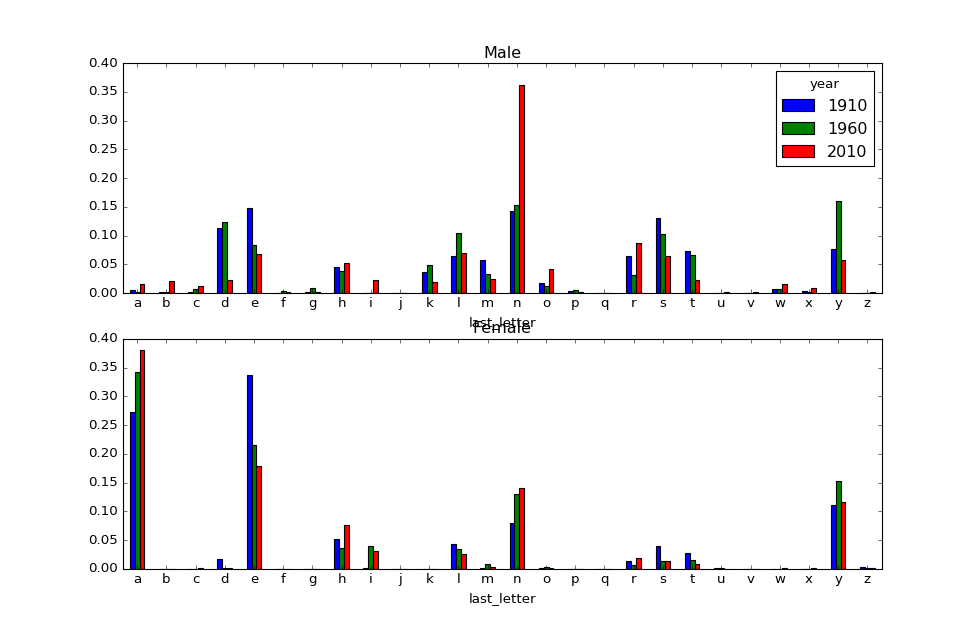

In [47]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 1, figsize=(10,8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female', legend=False)


In [50]:
letter_prop=table/table.sum().astype(float)

In [51]:
dny_ts=letter_prop.ix[['d','n','y'], 'M'].T
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083057,0.153217,0.075763
1881,0.083242,0.153212,0.077455
1882,0.085332,0.149561,0.077538
1883,0.084051,0.151653,0.079148
1884,0.086121,0.149926,0.080407


<IPython.core.display.Javascript object>


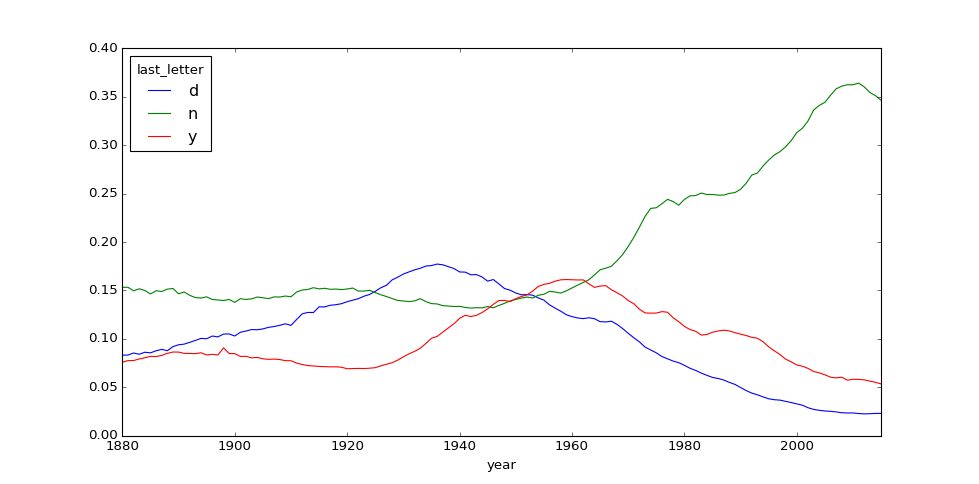

In [52]:
dny_ts.plot()

## Boy names that became girl names (and vice versa)

In [53]:
all_names=top1000.name.unique()

In [54]:
mask=np.array(['lesl' in x.lower() for x in all_names])

In [55]:
lesley_like=all_names[mask]

In [56]:
lesley_like

array(['Leslie', 'Lesley', 'Leslee', 'Lesli', 'Lesly'], dtype=object)

In [57]:
filtered=top1000[top1000.name.isin(lesley_like)]

In [58]:
filtered.groupby('name').births.sum()

name
Leslee       993
Lesley     35032
Lesli        929
Leslie    376034
Lesly      11431
Name: births, dtype: int64

In [59]:
table=pd.pivot_table(
    filtered,
    values='births',
    index='year',
    columns=['gender'],
    aggfunc='sum'
)

In [60]:
table=table.div(table.sum(1), axis=0)

In [61]:
table.tail()

gender,F,M
year,,
2011,1.0,NaN
2012,1.0,NaN
2013,1.0,NaN
2014,1.0,NaN
2015,1.0,NaN


<IPython.core.display.Javascript object>


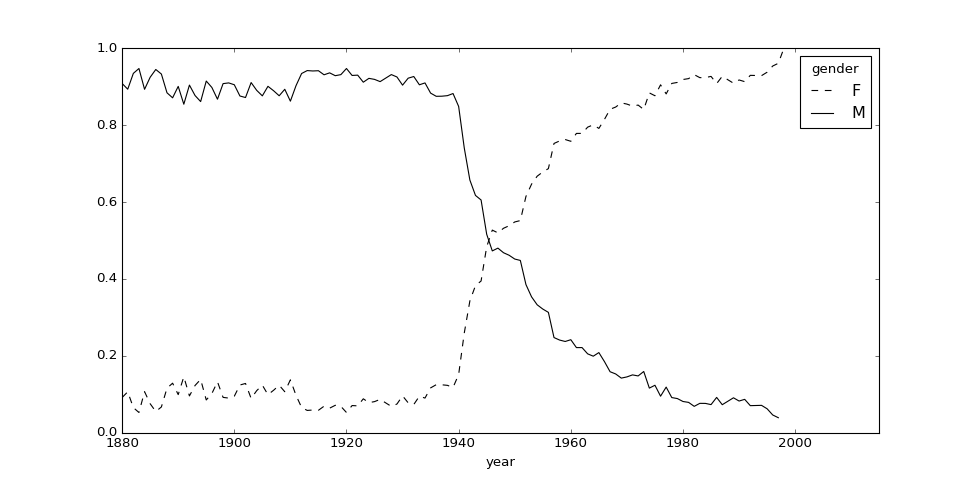

In [62]:
table.plot(style={'M': 'k-', 'F': 'k--'})